# Predicción de precios de Tesla (TSLA) con ARIMA y LSTM

---

El objetivo del proyecto es predecir el precio de cierre de las acciones de Tesla (TSLA) aplicando dos enfoques distintos:

ARIMA, para capturar patrones lineales y estacionales en la serie temporal.

LSTM, para aprender relaciones no lineales y dependencias de largo plazo.


## IMPORTAR LIBRERIAS

### Objetivo: cargar herramientas para datos, modelado y gráficos.

* yfinance para descargar históricos financieros.

* pandas y numpy para manipulación numérica.

* matplotlib para visualización.

* statsmodels (ARIMA) para series temporales clásicas.

* scikit-learn para métricas y escalado.

* tensorflow.keras para construir y entrenar el LSTM.

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-11-21 12:31:27.550679: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 12:31:27.564906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 12:31:28.121269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 12:31:30.144040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Reproducibilidad
Semillas: fija np.random.seed(42) y tf.random.set_seed(42) para reducir variabilidad entre ejecuciones en operaciones pseudoaleatorias (inicialización de pesos, etc.).

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

### Descargar datos
Función: descargar_datos() obtiene precios diarios de TSLA entre 2020-01-01 y 2025-01-01 con yf.download.

Salida: DataFrame con columnas estándar (Open, High, Low, Close, Adj Close, Volume).

Uso: data = descargar_datos() centraliza la obtención de datos y facilita parametrización.

In [32]:
def descargar_datos(ticker="TSLA", start="2020-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data
data = descargar_datos()

/tmp/ipykernel_13693/2027901811.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


### Exploración inicial
Vista rápida: print(data.head()) inspecciona las primeras filas.

Gráfico: se plotea data['Close'] para observar tendencia general del precio de cierre a lo largo del periodo.

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  33.232666  31.215334  31.580000  467164500


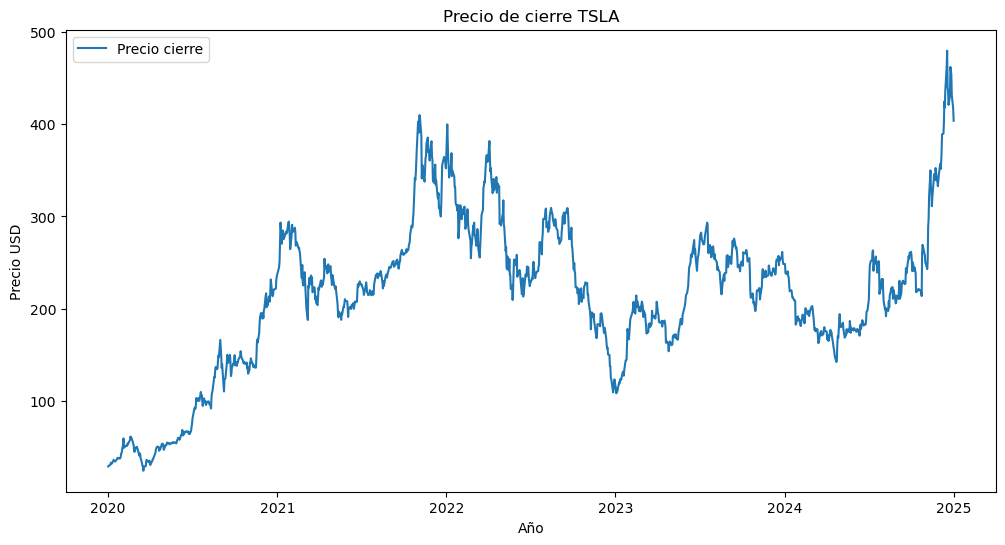

In [33]:
print(data.head())
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label="Precio cierre")
plt.title("Precio de cierre TSLA")
plt.ylabel('Precio USD')
plt.xlabel('Año')
plt.legend()
plt.show()

### Feature engineering con medias móviles
Cálculo: se añaden SMA_20 y SMA_50 sobre Close para suavizar y destacar tendencias de corto/medio plazo.

Visualización: se grafican las SMAs junto con el precio para identificar cruces y cambios de momentum.

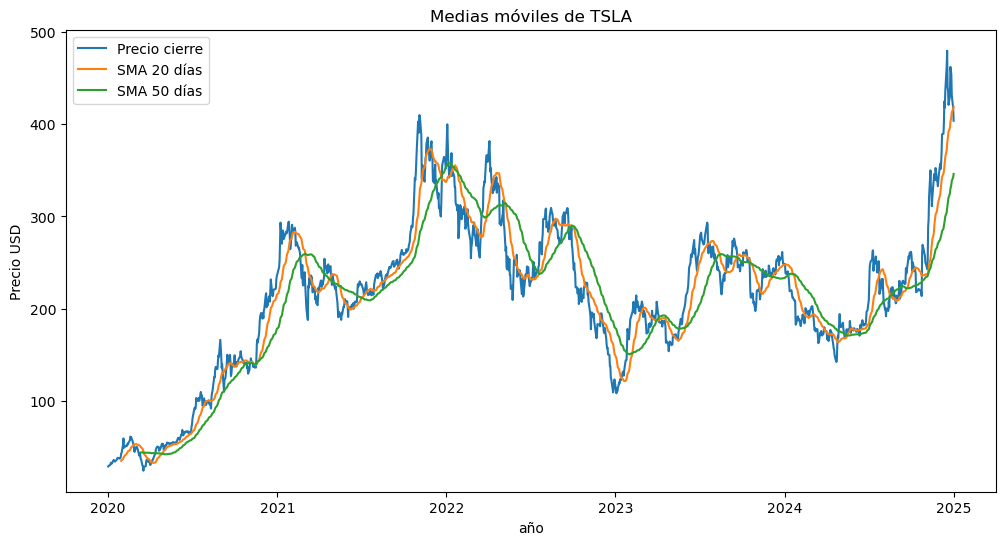

In [34]:
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Precio cierre')
plt.plot(data['SMA_20'], label='SMA 20 días')
plt.plot(data['SMA_50'], label='SMA 50 días')
plt.legend()
plt.ylabel('Precio USD')
plt.xlabel('año')
plt.title("Medias móviles de TSLA")
plt.show()

## ARIMA
* Inicio del bloque: Se define que a partir de aquí trabajamos con el modelo estadístico ARIMA para predecir la serie temporal.
---

Lo que hacemos es tomar la serie de precios de cierre de Tesla y limpiarla de valores nulos. Luego dividimos los datos en dos partes: 80% para entrenar y 20% para probar, siempre respetando el orden temporal. 

In [35]:
series = data['Close'].dropna()
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

### Entrenamiento del modelo:
Con el conjunto de entrenamiento ajustamos un modelo ARIMA(5,1,0), que combina rezagos autoregresivos y diferenciación para capturar la dinámica de la serie.

* Se ajusta un ARIMA con parámetros (5,1,0).

* p=5: usa 5 rezagos autoregresivos.

* d=1: diferencia la serie una vez para hacerla estacionaria.

* q=0: sin término de media móvil.

In [36]:
# Entrenar modelo ARIMA
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

/home/hassiel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hassiel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hassiel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Generación de pronósticos:
Después generamos predicciones sobre el tramo de prueba y calculamos métricas de error (RMSE y MAE) para evaluar el desempeño. 
* Se predicen tantos pasos como el tamaño del conjunto de prueba.

* Esto produce una serie de valores estimados alineados con las fechas de test.

In [38]:
predictions_arima = model_fit.forecast(steps=len(test))

/home/hassiel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Cálculo de métricas:

RMSE: raíz del error cuadrático medio, penaliza más los errores grandes.

MAE: error absoluto medio, mide desviación promedio.

Se imprimen los resultados para comparar desempeño.

In [39]:
rmse_arima = np.sqrt(mean_squared_error(test, predictions_arima))
mae_arima = mean_absolute_error(test, predictions_arima)
print(f"ARIMA -> RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}")

ARIMA -> RMSE: 73.04, MAE: 58.25


### Gráfico comparativo:
Finalmente, graficamos los valores reales frente a los estimados para visualizar cómo el modelo sigue la tendencia del precio.

* Se plotea la serie real (test) y la predicha (predictions_arima).

* Permite ver cómo el modelo sigue la tendencia real.

* Se añaden título y leyenda para claridad.

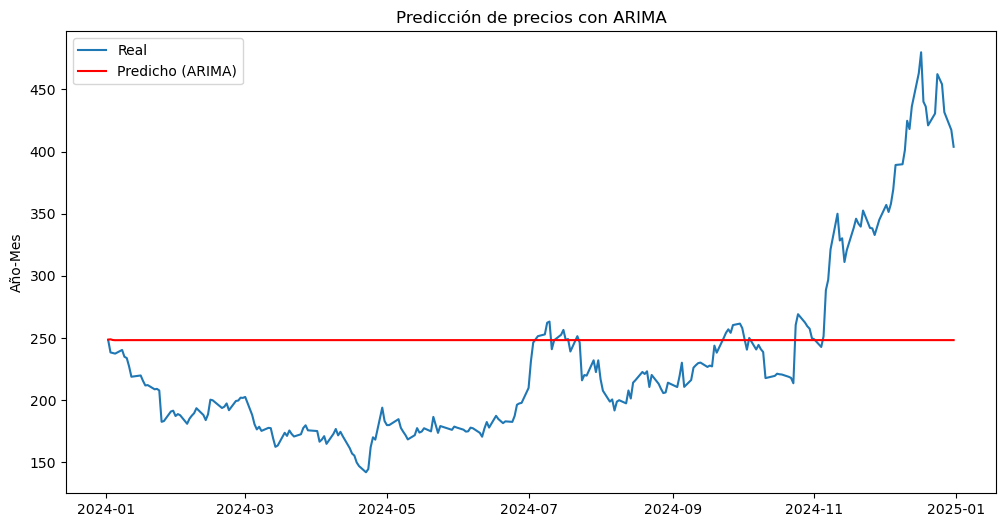

In [41]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, predictions_arima, label='Predicho (ARIMA)', color='red')
plt.legend()
plt.ylabel('Precio USD')
plt.ylabel('Año-Mes')
plt.title("Predicción de precios con ARIMA")
plt.show()

## LSTM
---

En este bloque se implementa un modelo de redes neuronales recurrentes LSTM para predecir el precio de cierre de Tesla. A diferencia de ARIMA, este enfoque busca capturar patrones no lineales y dependencias de largo plazo en la serie temporal.


---

Primero se normaliza la serie de precios con MinMaxScaler en el rango [0,1]. Esto es fundamental porque las LSTM funcionan mejor cuando los datos están escalados, evitando que valores grandes dominen el entrenamiento.

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(series.values.reshape(-1,1))

Se define la función create_sequences, que transforma la serie en ventanas de 60 días consecutivos. Cada ventana (X) se asocia con el valor del día siguiente (y). Así, el modelo aprende a predecir el próximo precio a partir de un historial de dos meses.

In [43]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

Las secuencias generadas se dividen en 80% para entrenamiento y 20% para prueba, manteniendo el orden temporal. Esto asegura que el modelo se entrene con datos pasados y se evalúe con datos futuros.

In [44]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

Se construye un modelo Sequential con dos capas LSTM de 50 neuronas cada una. La primera devuelve secuencias completas y la segunda condensa la información. Entre ellas se incluyen capas Dropout(0.2) para reducir sobreajuste. Finalmente, una capa Dense(1) produce la predicción del precio.

In [45]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

/home/hassiel/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


El modelo se compila con el optimizador Adam y pérdida MSE. Se entrena durante 50 épocas con lotes de 32 muestras, usando EarlyStopping para detener el entrenamiento si la pérdida deja de mejorar, evitando sobreentrenamiento y guardando los mejores pesos.

In [46]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0433
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0061
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0035
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0030
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoc

Se generan predicciones sobre el conjunto de prueba (X_test). Luego se aplica inverse_transform del escalador para devolver los valores a la escala original de precios. También se reescala y_test para comparar en la misma magnitud.

In [47]:
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Se calculan métricas de error: RMSE y MAE entre los valores reales y los predichos. Estas métricas permiten cuantificar qué tan bien el LSTM logra seguir la dinámica del precio.

In [48]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, predictions_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, predictions_lstm)
print(f"LSTM -> RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}")

LSTM -> RMSE: 16.40, MAE: 11.08


Finalmente, se grafica la serie real frente a las predicciones del LSTM. Esto permite observar visualmente cómo el modelo reproduce la tendencia y las variaciones del precio de cierre de Tesla en el periodo de prueba.

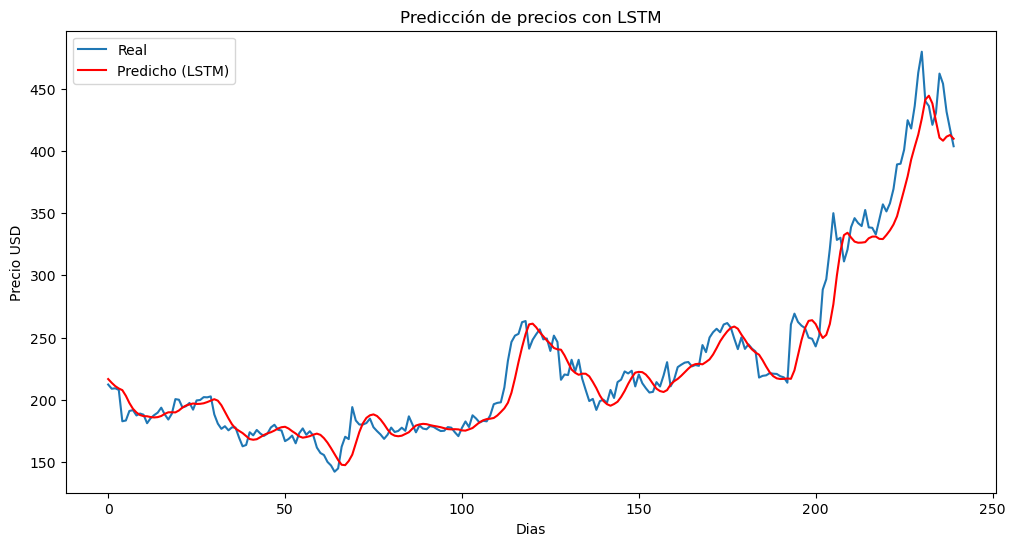

In [50]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Real')
plt.plot(predictions_lstm, label='Predicho (LSTM)', color='red')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Precio USD')
plt.title("Predicción de precios con LSTM")
plt.show()

## Conclusión
___

Este proyecto demuestra cómo dos enfoques distintos —uno estadístico (ARIMA) y otro basado en aprendizaje profundo (LSTM)— pueden aplicarse al análisis y predicción de series temporales financieras. ARIMA ofrece una solución rápida y transparente para capturar patrones lineales y estacionales, ideal cuando la serie es estacionaria o tiene estructura clara. Sin embargo, su capacidad de adaptación a dinámicas complejas es limitada, como se evidenció en la predicción plana observada en el gráfico.

Por otro lado, el modelo LSTM, aunque más exigente en términos computacionales y de preparación de datos, logra seguir mejor las fluctuaciones del mercado al aprender relaciones no lineales y dependencias de largo plazo. Su desempeño, reflejado en métricas como RMSE y MAE, muestra una mayor sensibilidad a los movimientos reales del precio, aunque también puede sobreajustarse si no se regula adecuadamente.